In [2]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16101)
<class 'numpy.ndarray'> (3187, 16101)


In [3]:
# Residual plots for MLR, XGBRF, and RNN

def figure_2_residuals_vs_predicted(y_true, predictions_dict, 
                                   output_path='/home/christianl/Zhang-Lab/Zhang Lab Code/Figures/'):
    """
    Generate residual vs. predicted scatter plots to detect heteroscedasticity
    and systematic bias.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples, n_genes)
        True target values (NOT flattened - function will handle it)
    predictions_dict : dict
        Dictionary of predictions by model
        Example: {'MLR': pred_mlr, 'XGBRFRegressor': pred_xgbrf}
    output_path : str
        Path to save figure
    """
    
    set_publication_style()
    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    
    model_names = list(predictions_dict.keys())
    
    # Flatten y_true once (it's the same for all models)
    y_true_flat = y_true.ravel()
    
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        
        # Get predictions for this model and flatten
        y_pred = predictions_dict[model_name]
        y_pred_flat = y_pred.ravel()
        
        # Calculate residuals
        residuals = y_true_flat - y_pred_flat
        
        # Scatter plot
        ax.scatter(y_pred_flat, residuals, alpha=0.5, s=30,
                  color=MODEL_COLORS.get(model_name, '#1f77b4'),
                  edgecolors='none')
        
        # Zero line (perfect predictions have residual = 0)
        ax.axhline(y=0, color='k', linestyle='--', lw=2, alpha=0.5, 
                   label='Zero residual')
        
        # Trend line using moving average to detect systematic patterns
        sorted_indices = np.argsort(y_pred_flat)
        y_pred_sorted = y_pred_flat[sorted_indices]
        residuals_sorted = residuals[sorted_indices]
        
        # Simple moving average as trend detector
        window = max(100, len(y_pred_flat) // 100)  # Adjust window size
        if len(y_pred_flat) > window:
            moving_avg = pd.Series(residuals_sorted).rolling(
                window=window, center=True, min_periods=1).mean()
            ax.plot(y_pred_sorted, moving_avg, color='red', lw=2.5, 
                   alpha=0.7, label='Trend (moving avg)')
        
        # Compute heteroscedasticity metric
        # Split into quartiles and compute variance ratio
        n_points = len(y_pred_flat)
        quartile_size = n_points // 4
        
        if quartile_size > 10:  # Only if we have enough data
            quartiles = [
                sorted_indices[:quartile_size],  # Q1
                sorted_indices[quartile_size:2*quartile_size],  # Q2
                sorted_indices[2*quartile_size:3*quartile_size],  # Q3
                sorted_indices[3*quartile_size:]  # Q4
            ]
            variances = [np.var(residuals[q]) for q in quartiles if len(q) > 0]
            
            if len(variances) > 0 and np.min(variances) > 0:
                hetero_ratio = np.max(variances) / np.min(variances)
            else:
                hetero_ratio = np.nan
        else:
            hetero_ratio = np.nan
        
        # Statistical tests
        # 1. Mean should be close to 0 (no systematic bias)
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        
        # 2. Breusch-Pagan test for heteroscedasticity (optional)
        # Would require statsmodels - skip for simplicity
        
        # Labels and formatting
        ax.set_xlabel('Predicted Expression', fontsize=12, fontweight='bold')
        ax.set_ylabel('Residuals (Observed - Predicted)', fontsize=12, fontweight='bold')
        ax.set_title(model_name, fontsize=13, fontweight='bold')
        
        # Text box with diagnostics
        if not np.isnan(hetero_ratio):
            textstr = (f"Mean Residual: {mean_residual:.4f}\n"
                      f"Std Dev: {std_residual:.4f}\n"
                      f"Hetero Ratio: {hetero_ratio:.2f}x")
        else:
            textstr = (f"Mean Residual: {mean_residual:.4f}\n"
                      f"Std Dev: {std_residual:.4f}")
        
        # Interpretation guidance
        if abs(mean_residual) > 0.1:
            textstr += "\n⚠ Systematic bias"
        if not np.isnan(hetero_ratio) and hetero_ratio > 3.0:
            textstr += "\n⚠ Heteroscedastic"
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Figure 2 saved to {output_path}")
    plt.show()
    
    # Return diagnostic statistics for further analysis
    diagnostics = {}
    for model_name in model_names:
        y_pred = predictions_dict[model_name]
        y_pred_flat = y_pred.ravel()
        residuals = (y_true_flat - y_pred_flat)
        
        diagnostics[model_name] = {
            'mean_residual': np.mean(residuals),
            'std_residual': np.std(residuals),
            'median_residual': np.median(residuals),
            'max_abs_residual': np.max(np.abs(residuals))
        }
    
    return diagnostics


# Alternative: More comprehensive residual diagnostic plots
def figure_2_comprehensive_residuals(y_true, predictions_dict,
                                    output_path='/home/christianl/Zhang-Lab/Zhang Lab Code/Figures/figure_2_residuals_comprehensive.png'):
    """
    More comprehensive residual diagnostics with additional plots.
    Creates a 3x3 grid with multiple diagnostic views.
    """
    
    set_publication_style()
    n_models = len(predictions_dict)
    model_names = list(predictions_dict.keys())
    
    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(3, n_models, hspace=0.3, wspace=0.3)
    
    y_true_flat = y_true.ravel()
    
    for idx, model_name in enumerate(model_names):
        y_pred = predictions_dict[model_name]
        y_pred_flat = y_pred.ravel()
        residuals = y_true_flat - y_pred_flat
        
        # Row 1: Residuals vs Predicted
        ax1 = fig.add_subplot(gs[0, idx])
        ax1.scatter(y_pred_flat, residuals, alpha=0.3, s=20,
                   color=MODEL_COLORS.get(model_name, '#1f77b4'))
        ax1.axhline(y=0, color='k', linestyle='--', lw=2, alpha=0.5)
        ax1.set_xlabel('Predicted Values')
        ax1.set_ylabel('Residuals')
        ax1.set_title(f'{model_name} - Residuals vs Predicted')
        ax1.grid(True, alpha=0.3)
        
        # Row 2: Residual histogram
        ax2 = fig.add_subplot(gs[1, idx])
        ax2.hist(residuals, bins=100, alpha=0.7, 
                color=MODEL_COLORS.get(model_name, '#1f77b4'),
                edgecolor='black')
        ax2.axvline(x=0, color='k', linestyle='--', lw=2, alpha=0.5)
        ax2.axvline(x=np.mean(residuals), color='r', linestyle='-', lw=2,
                   label=f'Mean={np.mean(residuals):.4f}')
        ax2.set_xlabel('Residual Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Residual Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Row 3: Q-Q plot
        ax3 = fig.add_subplot(gs[2, idx])
        stats.probplot(residuals, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot (Normality Check)')
        ax3.grid(True, alpha=0.3)
        
        # Add statistics text to first plot
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        textstr = f'μ={mean_res:.4f}\nσ={std_res:.4f}'
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Comprehensive residual plots saved to {output_path}")
    plt.show()


Figure 2 saved to figure2_v2(centered).png


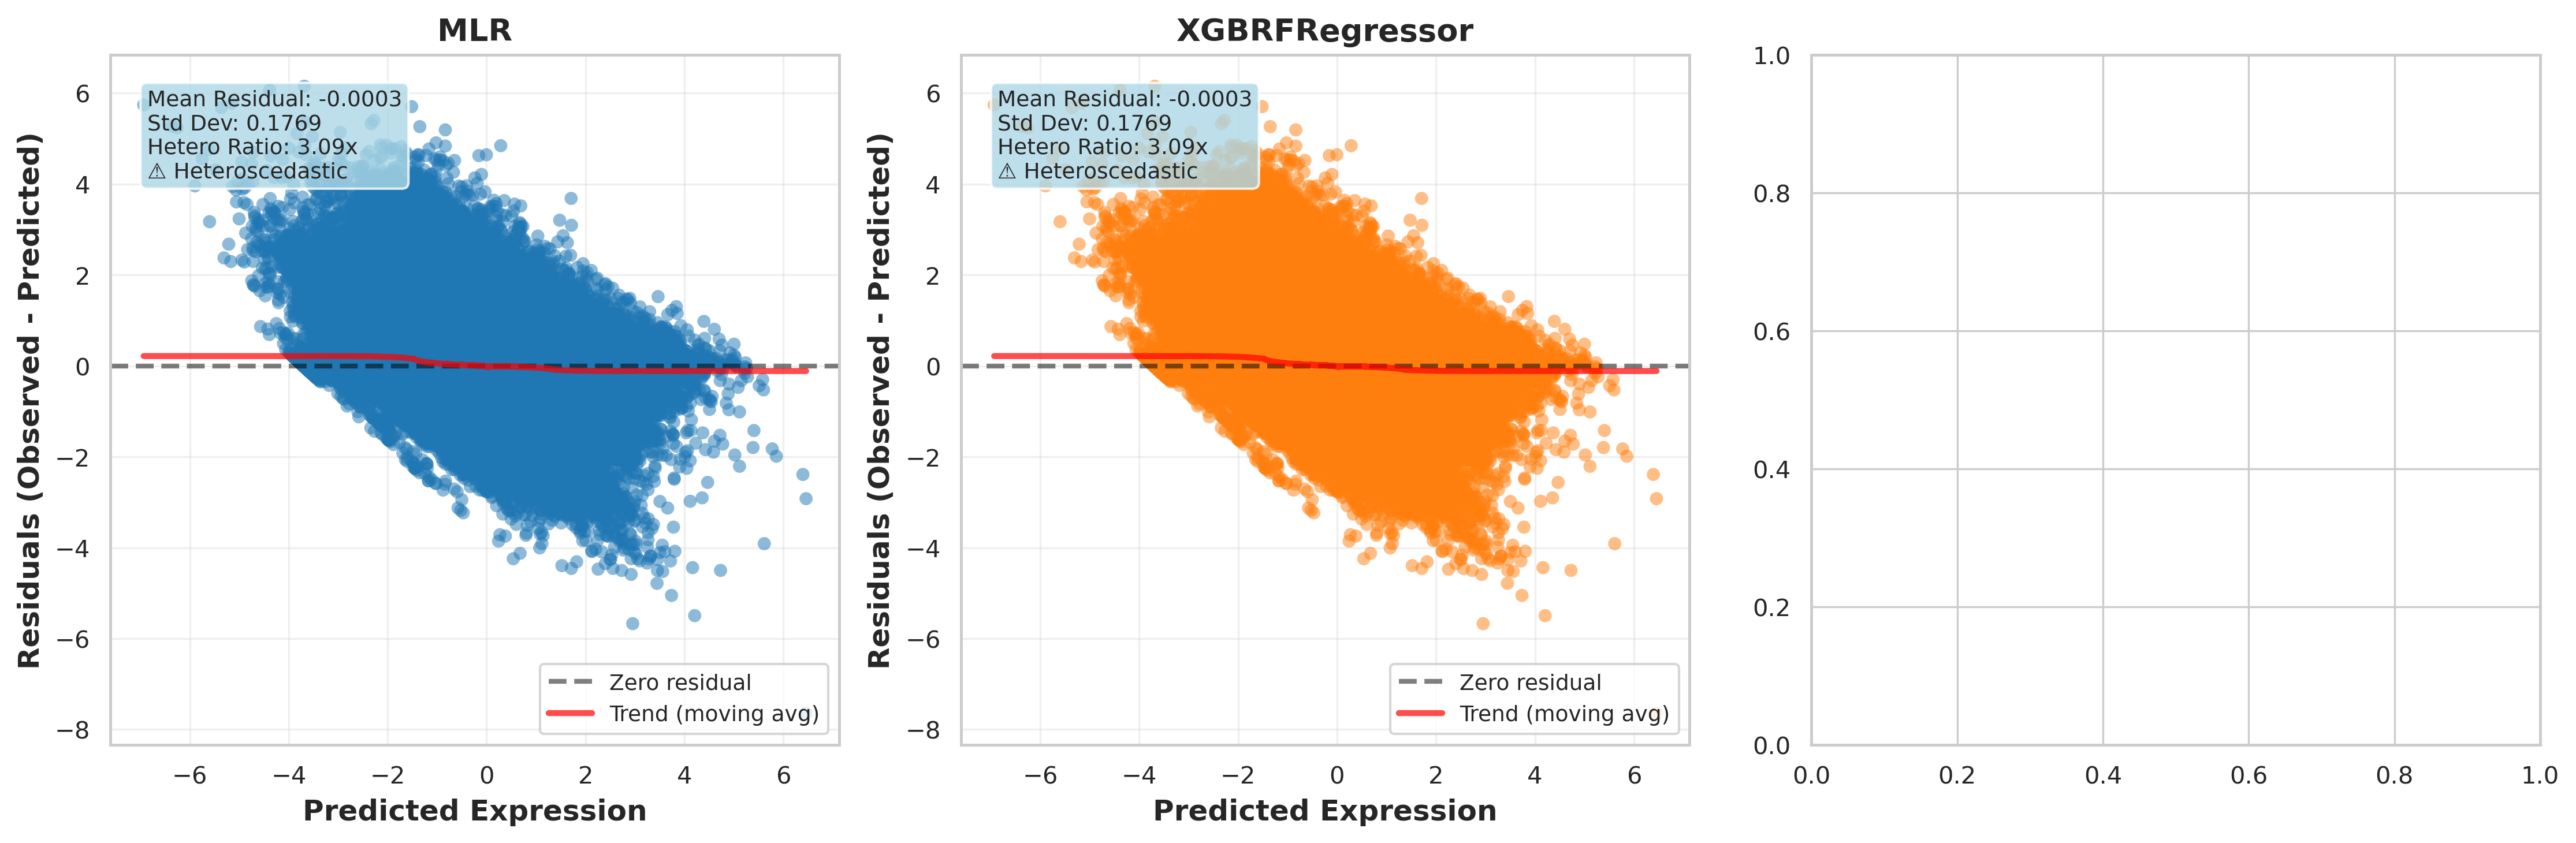

{'MLR': {'mean_residual': np.float64(-0.0002757670053278083),
  'std_residual': np.float64(0.17686568969239805),
  'median_residual': np.float64(-4.440892098500626e-16),
  'max_abs_residual': np.float64(7.64615978526304)},
 'XGBRFRegressor': {'mean_residual': np.float64(-0.0002757670053278083),
  'std_residual': np.float64(0.17686568969239805),
  'median_residual': np.float64(-4.440892098500626e-16),
  'max_abs_residual': np.float64(7.64615978526304)}}

In [4]:
figure_2_residuals_vs_predicted(y_test_centered, predictions, "figure2_v2(centered).png")